# Predict female behavior from inferred single neuron activity

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_lin_single

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30

# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'ln'  # lin-nonlinear neural model
NRL_MDL = 'dyn'  # dynamical neural model

TARGS = ['FFV_MN_60', 'FFV']

FIT_LIN = skl_fit_lin_single

In [2]:
FSTRAIN = 'data/simple/strains.csv'
FBAKER_FIT_PARAM = f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv'

FPFX_NEUR_BHV = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
FPFX_BHV_XTD = f'data/simple/behav_xtd/behav_xtd'

FSAVE = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}_{"_".join(STRAINS).lower()}_{TARGS[0].lower()}.npy'

DFBAKER_FIT_PARAM = pd.read_csv(FBAKER_FIT_PARAM)
R_COLS_USE = [f'R_{ir}' for ir in DFBAKER_FIT_PARAM.EXPT_ID]

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [7]:
r2s_train = {targ: np.nan * np.zeros((NSPLIT, len(R_COLS_USE))) for targ in TARGS}
r2s_test = {targ: np.nan * np.zeros((NSPLIT, len(R_COLS_USE))) for targ in TARGS}

for csplit in range(NSPLIT):
    sys.stdout.write(f'Split {csplit}')
    irnd = np.random.permutation(NTR)
    idxs_train = ISTRAIN[irnd[:NTRAIN]]
    idxs_test = ISTRAIN[irnd[NTRAIN:]]
    
    rslt = skl_fit_lin_single([FPFX_NEUR_BHV, FPFX_BHV_XTD], R_COLS_USE, TARGS, idxs_train, idxs_test, progress=True)
    
    for targ in TARGS:
        r2s_train[targ][csplit, :] = rslt.r2_train[targ]
        r2s_test[targ][csplit, :] = rslt.r2_test[targ]
    
    sys.stdout.write('\n')

# save r2, weights, and example predictions
save_data = {
    'r2s_train': r2s_train,
    'r2s_test': r2s_test,
    'ntr': NTR,
    'nsplit': NSPLIT,
}

np.save(FSAVE, np.array([save_data]))

Split 0Fitting...
..
Split 1Fitting...
..
Split 2Fitting...
..


Max train R2: 0.21311315355736113
Max test R2: -2.5490384230418046
Max train R2: 0.013272320048386224
Max test R2: -0.06808948603942107


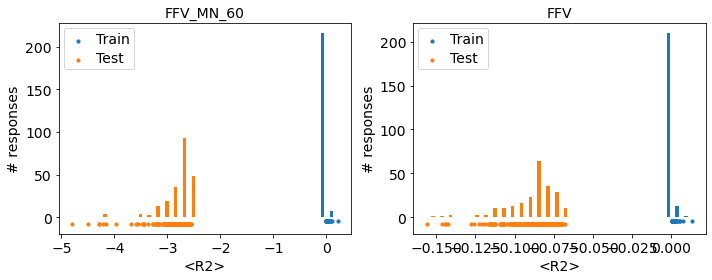

In [8]:
data = np.load(FSAVE, allow_pickle=True)[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

for targ, ax in zip(TARGS, axs):
    r2_train_means = data['r2s_train'][targ].mean(axis=0)
    r2_test_means = data['r2s_test'][targ].mean(axis=0)

    ax.hist(np.transpose([r2_train_means, r2_test_means]), bins=30)
    ax.scatter(r2_train_means, -4*np.ones(len(r2_train_means)), s=10)
    ax.scatter(r2_test_means, -8*np.ones(len(r2_test_means)), s=10)
    ax.set_title(targ)
    ax.legend(['Train', 'Test'])

    set_plot(ax, x_label='<R2>', y_label='# responses', font_size=14)

    print('Max train R2:', np.nanmax(r2_train_means))
    print('Max test R2:', np.nanmax(r2_test_means))